44.00699833724652
44.00699833724652
18.366955541360774
61.76171488083117
45.65845620289663
4.579069071989996
-----------------------------  -------------  ----------------  ----------------  ----------------  --------------
Image 0 vs image:                 0                1                 2                 3               4
mean                              0               -7.54473          -8.09669          -8.07097        -6.85452
avg_hash                          0                0                 0                 0.00378072      0.00378072
p_hash                            0                0.0226843         0.0378072         0.0831758       0.0529301
d_hash                            0                0.00189036        0                 0.00378072      0.00567108
haar_hash                         0                0.0226843         0.0567108         0.0491493       0.0321361
db4_hash                          0                0.0661626         0.10586           0.111531        0.0

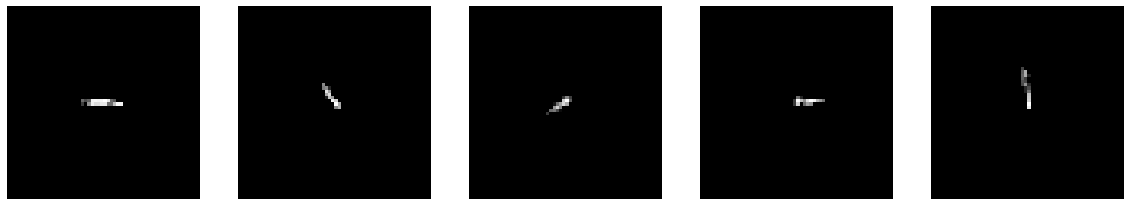

In [4]:
import numpy as np

from dataset_loader import load_from_file
from tabulate import tabulate
from matplotlib.pyplot import figure, imshow, axis
from commons import *
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.ndimage import rotate

# obrót do poziomu, metodami:
# 1. hough lines
# 2. tomkowe
# 3. tamtą pierwszą biblioteką od eliciticy
# informacja wzjaemna - między jednym obrazkiem a porównywanym
# jeszcze te metryki: https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6


DOTS_DST = 'cache/dots_v2.pickle'
TRACKS_DST = 'cache/tracks_v2.pickle'
WORMS_DST = 'cache/worms_v2.pickle'
ARTIFACTS_DST = 'cache/artifacts_v2.pickle'

DOTS_DSTx4 = 'cache/dots_v3.pickle'
TRACKS_DSTx4 = 'cache/tracks_v3.pickle'
WORMS_DSTx4 = 'cache/worms_v3.pickle'
ARTIFACTS_DSTx4 = 'cache/artifacts_v3.pickle'


tf_classes = [ tf.keras.metrics.AUC,
    tf.keras.metrics.Accuracy,
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.BinaryCrossentropy,
    tf.keras.metrics.BinaryIoU,
    tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.CategoricalCrossentropy,
    tf.keras.metrics.CategoricalHinge,
    tf.keras.metrics.CosineSimilarity,
    tf.keras.metrics.FalseNegatives,
    tf.keras.metrics.FalsePositives,
    tf.keras.metrics.Hinge,
    #tf.keras.metrics.IoU,
    tf.keras.metrics.KLDivergence,
    tf.keras.metrics.LogCoshError,
    tf.keras.metrics.Mean,
    tf.keras.metrics.MeanAbsoluteError,
    tf.keras.metrics.MeanAbsolutePercentageError,
    #tf.keras.metrics.MeanIoU,
    #tf.keras.metrics.MeanMetricWrapper,
    #tf.keras.metrics.MeanRelativeError,
    tf.keras.metrics.MeanSquaredError,
    tf.keras.metrics.MeanSquaredLogarithmicError,
    #tf.keras.metrics.MeanTensor,
    #tf.keras.metrics.Metric,
    #tf.keras.metrics.OneHotIoU,
    #tf.keras.metrics.OneHotMeanIoU,
    tf.keras.metrics.Poisson,
    tf.keras.metrics.Precision,
    #tf.keras.metrics.PrecisionAtRecall,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.RecallAtPrecision,
    tf.keras.metrics.RootMeanSquaredError,
    #tf.keras.metrics.SensitivityAtSpecificity,
    tf.keras.metrics.SparseCategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalCrossentropy,
    tf.keras.metrics.SparseTopKCategoricalAccuracy,
    #tf.keras.metrics.SpecificityAtSensitivity,
    tf.keras.metrics.SquaredHinge,
    tf.keras.metrics.Sum,
    tf.keras.metrics.TopKCategoricalAccuracy,
    tf.keras.metrics.TrueNegatives,
    tf.keras.metrics.TruePositives ]

def generic_tf_metrics(cls):
    def tf_metrics(image, recon):
        m = cls()
        m.update_state(image, recon)
        return m.result().numpy()
    return tf_metrics, cls.__name__

tf_mean = generic_tf_metrics(tf.keras.metrics.Mean)


def tf_kl_divergence(image, recon):
    m = tf.keras.metrics.KLDivergence()
    m.update_state(image, recon)
    return m.result().numpy()


def tf_accuracy(image, recon):
    m = tf.keras.metrics.Accuracy()
    m.update_state(image, recon)
    return m.result().numpy()

def tf_mse(image, recon):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(image, recon)
    return m.result().numpy()




funcs = [
    (dm_func_mean2, 'mean'),
    (dm_func_avg_hash, 'avg_hash'),
    (dm_func_p_hash, 'p_hash'),
    (dm_func_d_hash,  'd_hash'),
    (dm_func_haar_hash,  'haar_hash'),
    (dm_func_db4_hash, 'db4_hash')
] #, tf_kl_divergence, tf_accuracy, tf_mse]
for c in tf_classes:
    funcs.append(generic_tf_metrics(c))


def round_normalize(image):
    label_img = np.where(image > 0, 1, 0)
    #label_img = label(img, connectivity=img.ndim)
    props = regionprops(label_img)

    deg = props[0].orientation*(180/np.pi)
    print(deg)
    mask = np.where(image == 0, 0.0, 1.0)
    rotated_mask = rotate(mask, deg, reshape=False)
    rotated_image = rotate(image, deg, reshape=False)
    rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
    rotated_image = np.where(rotated_image < 0, 0, rotated_image)
    rotated_image = np.where(rotated_image > 1, 1, rotated_image)
    return rotated_image


def showImagesMatrix(images, col=10):

    hSize = 20
    wSize = 20

    fig = figure( figsize=(wSize, hSize))
    number_of_files = len(images)
    row = number_of_files // col
    if (number_of_files%col != 0):
        row += 1

    row_head = ['Image 0 vs image:']
    row_funcs = []

    for f, n in funcs:
        row_funcs.append([n])

    img0 = round_normalize(images[0])
    img0 = np.expand_dims(img0, axis=-1)

    for i in range(number_of_files):
        row_head.append(str(i))
        a=fig.add_subplot(row,col,i+1)
        image = round_normalize(images[i])
        image = np.expand_dims(image, axis=-1)
        imshow(image,cmap='Greys_r')
        axis('off')

        #print('%010s | %6.3f' % ('dm_func_mean2', v))
        for fi, (f, n) in enumerate(funcs):
            v = f(img0, image)
            row_funcs[fi].append(str(v))

    table = [row_head, *row_funcs]
    print(tabulate(table))



images, augmented = load_from_file(TRACKS_DST)
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

-----------------------------  -------------  --------------  -------------  ----------------  ----------------
Image 0 vs image:                 0              1               2                3                 4
mean                              0             -7.37842         0               -9.06188          -9.10329
avg_hash                          0              0.00189036      0                0                 0
p_hash                            0              0.0378072       0                0.0604915         0.0604915
d_hash                            0              0.00189036      0                0                 0
haar_hash                         0              0.0604915       0                0.0453686         0.0453686
db4_hash                          0              0.0982987       0                0.0151229         0.0151229
AUC                               1              0.605371        1                0.934612          0.89097
Accuracy                          1 

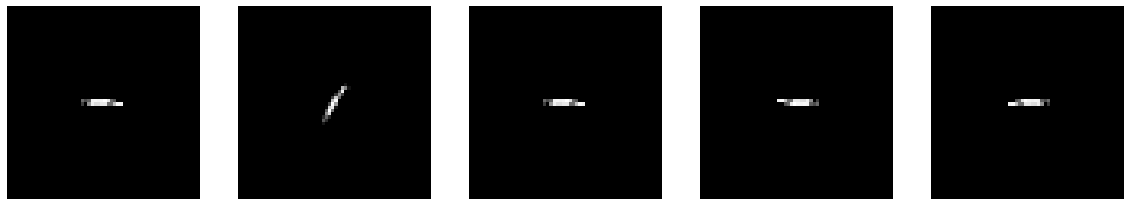

In [9]:
showImagesMatrix([images[0], augmented[0], augmented[2], augmented[5], augmented[16]], 5)

-----------------------------  -------------  ----------------  ----------------  ----------------  --------------
Image 0 vs image:                 0                1                 2                 3               4
mean                              0               -7.54473          -8.09669          -8.07097        -6.85452
avg_hash                          0                0                 0                 0.00378072      0.00378072
p_hash                            0                0.0226843         0.0378072         0.0831758       0.0529301
d_hash                            0                0.00189036        0                 0.00378072      0.00567108
haar_hash                         0                0.0226843         0.0567108         0.0491493       0.0321361
db4_hash                          0                0.0661626         0.10586           0.111531        0.0907372
AUC                               1                0.585382          0.672625          0.716395       

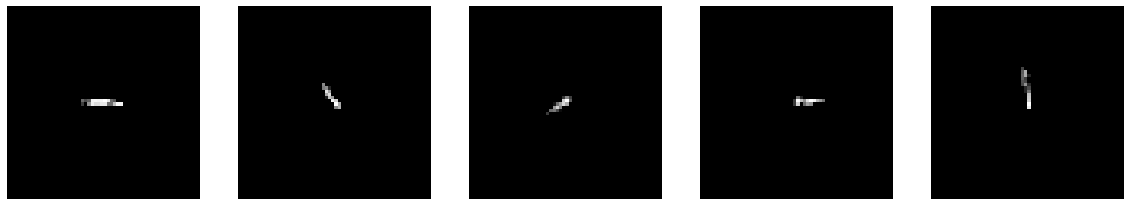

In [10]:
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

-----------------------------  --------------  ---------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                1                 2                 3                 4
mean                              0               -5.41299          -2.68695          -2.68695          -2.68695
avg_hash                          0                0                 0                 0                 0
p_hash                            0                0                 8                 8                 8
d_hash                            0                0                 0                 0                 0
haar_hash                         0                1.25             10.5              10.5               4.5
db4_hash                          0                4.25             19                19                 9
AUC                               1                0.999861          0.499722          0.499722          0.499722
Accuracy    

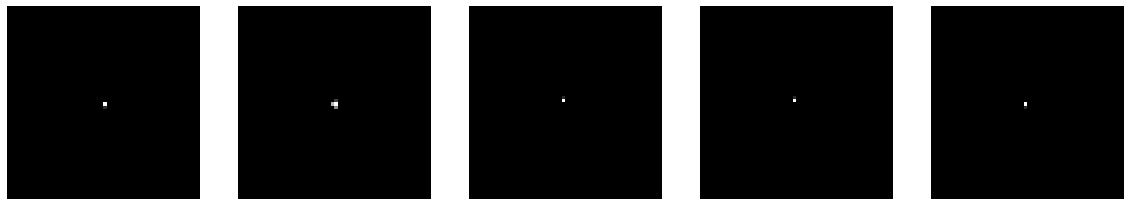

In [11]:
images_dots, augmented_dots = load_from_file(DOTS_DST)

showImagesMatrix([images_dots[0], augmented_dots[0], augmented_dots[2], augmented_dots[5], augmented_dots[16]], 5)

-----------------------------  --------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                 1                 2                 3                 4
mean                              0                -2.76714          -4.75607          -1.04214          -1.50167
avg_hash                          0                 0                 0                 0                 0
p_hash                            0                 8                 0                 8                 0
d_hash                            0                 0                 0                 0                 0
haar_hash                         0                 6.5               3.5               6                 3.5
db4_hash                          0                10                 5                 9.5               6.25
AUC                               1                 0.749514          0.999583          0.749236          0.999444


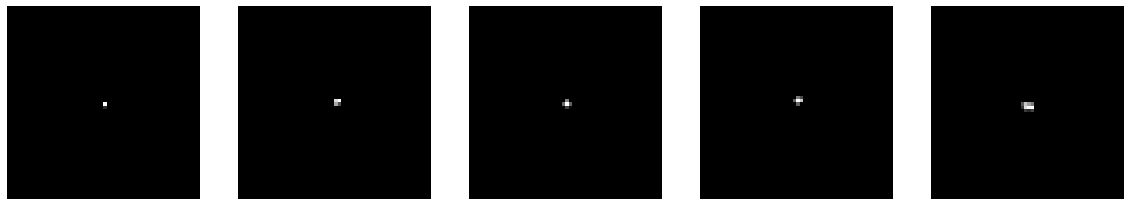

In [12]:
showImagesMatrix([images_dots[0], images_dots[1], images_dots[2], images_dots[3], images_dots[4]], 5)

-----------------------------  -------------  ----------------  --------------  --------------  --------------
Image 0 vs image:                 0                1               2               3               4
mean                              0              -10.3988         -9.01399        -9.01399        -9.40571
avg_hash                          0                0.000991736     0.000661157     0.000661157     0.000661157
p_hash                            0                0               0.0105785       0.0105785       0.0105785
d_hash                            0                0.000991736     0.00132231      0.00132231      0.00132231
haar_hash                         0                0.00595041      0.0145455       0.0145455       0.00528926
db4_hash                          0                0.0168595       0.0340496       0.0340496       0.0168595
AUC                               1                0.825325        0.548318        0.548318        0.696115
Accuracy                

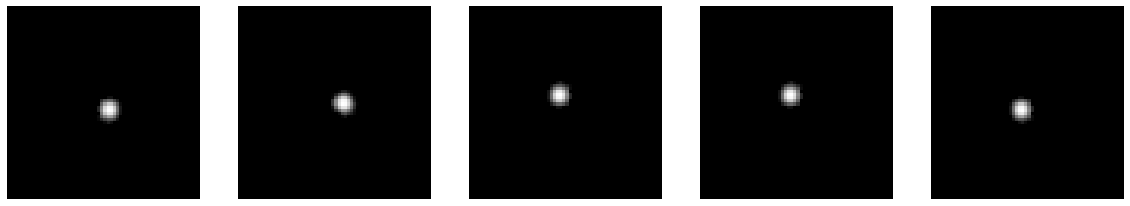

In [13]:
images_dots4x, augmented_dots4x = load_from_file(DOTS_DSTx4)
showImagesMatrix([images_dots4x[0], augmented_dots4x[0], augmented_dots4x[2], augmented_dots4x[5], augmented_dots4x[16]], 5)

-----------------------------  -------------  --------------  --------------  --------------  --------------
Image 0 vs image:                 0              1               2               3               4
mean                              0             -8.17037       -10.0407         -7.59865        -7.4948
avg_hash                          0              0.000661157     0.000330579     0.000330579     0.00165289
p_hash                            0              0.0105785       0               0               0
d_hash                            0              0.00132231      0.00165289      0.00132231      0.00198347
haar_hash                         0              0.0158678       0.00661157      0.00231405      0.00528926
db4_hash                          0              0.0416529       0.0161983       0.0201653       0.0145455
AUC                               1              0.620105        0.933594        0.99953         0.975866
Accuracy                          1              0.9

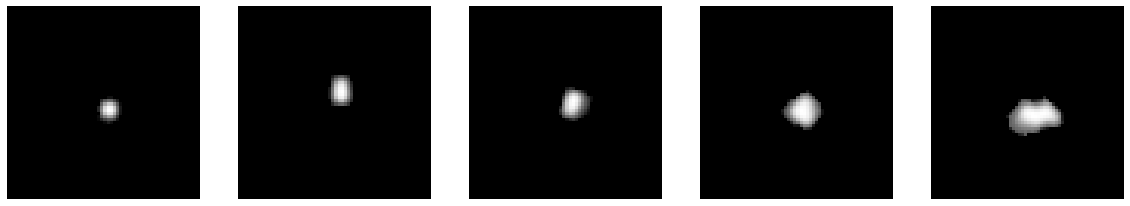

In [14]:
showImagesMatrix([images_dots4x[0], images_dots4x[1], images_dots4x[2], images_dots4x[3], images_dots4x[4]], 5)

-----------------------------  -------------  ----------------  --------------  --------------  ----------------
Image 0 vs image:                 0                1               2               3                 4
mean                              0               -8.91179        -7.86473        -7.86473          -9.57585
avg_hash                          0                0               0               0                 0
p_hash                            0                0.0187305       0.0332986       0.0332986         0.0332986
d_hash                            0                0               0.00416233      0.00416233        0.00208117
haar_hash                         0                0.0208117       0.00832466      0.00832466        0.00832466
db4_hash                          0                0.0645161       0.130073        0.130073          0.118626
AUC                               1                0.707174        0.592987        0.592987          0.723963
Accuracy         

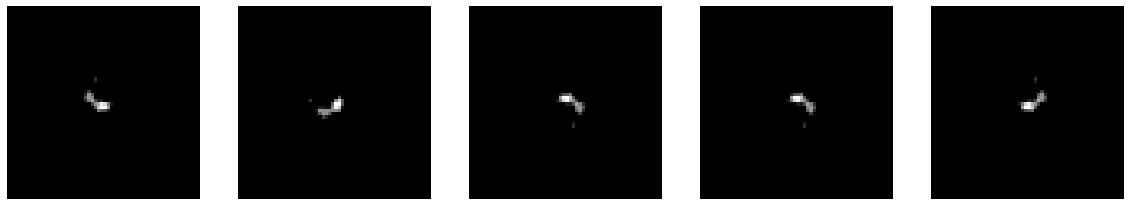

In [15]:
images_worms, augmented_worms = load_from_file(WORMS_DST)
showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

-----------------------------  -------------  ----------------  --------------  --------------  --------------
Image 0 vs image:                 0                1               2               3               4
mean                              0               -8.50968        -6.87625        -7.62669        -6.90466
avg_hash                          0                0               0.00208117      0.00104058      0
p_hash                            0                0.0332986       0.00832466      0.0166493       0.0166493
d_hash                            0                0.00312175      0.00416233      0.00520291      0.00208117
haar_hash                         0                0.00728408      0.00520291      0.0260146       0.00728408
db4_hash                          0                0.114464        0.0780437       0.120708        0.0780437
AUC                               1                0.708227        0.738221        0.578883        0.692025
Accuracy                          

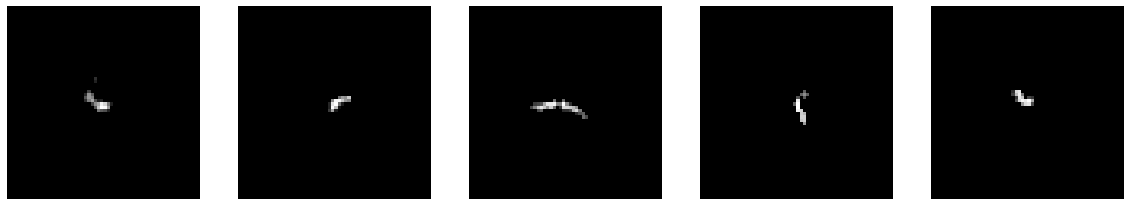

In [16]:
showImagesMatrix([images_worms[0], images_worms[1], images_worms[2], images_worms[3], images_worms[4]], 5)

-----------------------------  -------------  ----------------  ---------------  --------------
Image 0 vs image:                 0                1                2               3
mean                              0               -7.67865         -7.94841        -6.90541
avg_hash                          0                0                0               0.00189036
p_hash                            0                0.00756144       0.0378072       0.0378072
d_hash                            0                0.00189036       0.00378072      0.00567108
haar_hash                         0                0.0378072        0.0623819       0.0548204
db4_hash                          0                0.137996         0.0661626       0.111531
AUC                               1                0.78002          0.521605        0.754993
Accuracy                          1                0.988611         0.993333        0.981667
BinaryAccuracy                    0.993611         0.993611         0

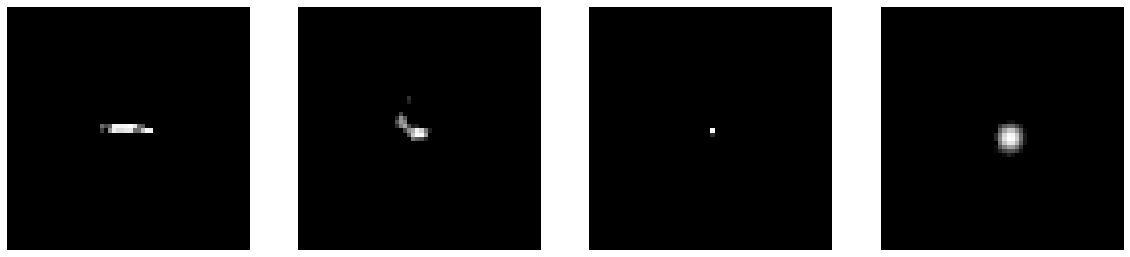

In [17]:
showImagesMatrix([images[0], images_worms[0], images_dots[0], images_dots4x[0][2:62,2:62]], 4)